In [ ]:
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

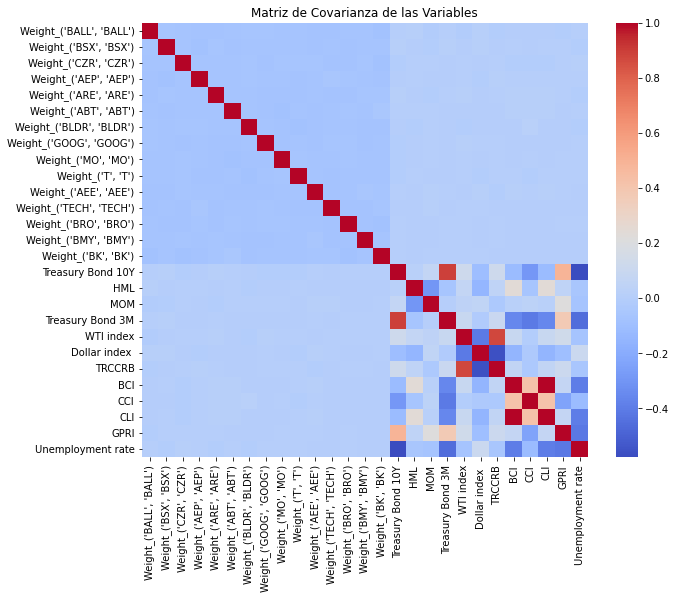

In [2]:
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)

# Preprocesamiento
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cov_matrix = np.cov(X_scaled, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cov_matrix, columns=X.columns, index=X.columns), cmap="coolwarm", annot=False)
plt.title("Matriz de Covarianza de las Variables")
plt.show()

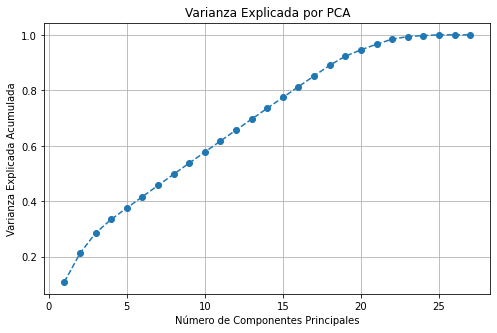

In [3]:
# Aplicar PCA sin especificar número de componentes
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada acumulada
var_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficar la varianza explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(var_explicada_acumulada) + 1), var_explicada_acumulada, marker='o', linestyle='--')
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

In [5]:
# Aplicar PCA con 21 componentes principales
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_scaled)

# Imprimir varianza explicada total
total_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA aplicado: {X_pca.shape[1]} componentes principales retienen el {total_variance:.2%} de la varianza")


PCA aplicado: 21 componentes principales retienen el 96.62% de la varianza


[I 2025-03-13 10:44:33,092] A new study created in memory with name: no-name-2132d62e-8c85-4359-82f2-04ec9e952dc3
[I 2025-03-13 10:44:33,842] Trial 0 finished with value: 0.8099341755813088 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.04599143576113169, 'subsample': 0.8746697772182715, 'colsample_bytree': 0.9425857524400333, 'gamma': 0.04394281198963344, 'reg_alpha': 0.36007451880419294, 'reg_lambda': 0.5204350283274566}. Best is trial 0 with value: 0.8099341755813088.
[I 2025-03-13 10:44:34,892] Trial 1 finished with value: 0.8984033719403337 and parameters: {'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.04760336713368246, 'subsample': 0.901233590777498, 'colsample_bytree': 0.8939209993855132, 'gamma': 0.042272113464528985, 'reg_alpha': 0.20831945622171008, 'reg_lambda': 0.231952954663363}. Best is trial 1 with value: 0.8984033719403337.
[I 2025-03-13 10:44:35,518] Trial 2 finished with value: 0.7527852144949438 and parameters: {'n_estimators': 17

[I 2025-03-13 10:44:56,682] Trial 21 finished with value: 0.9182416495124801 and parameters: {'n_estimators': 232, 'max_depth': 4, 'learning_rate': 0.04957553383031168, 'subsample': 0.8290040017716849, 'colsample_bytree': 0.9248451178856161, 'gamma': 0.08632629489944774, 'reg_alpha': 0.45966067652614184, 'reg_lambda': 0.461203601271939}. Best is trial 13 with value: 0.9193423428648503.
[I 2025-03-13 10:44:58,279] Trial 22 finished with value: 0.9159803359931986 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.049914774315142255, 'subsample': 0.8296366756161787, 'colsample_bytree': 0.9350409504535147, 'gamma': 0.0859208419305152, 'reg_alpha': 0.4320358848093356, 'reg_lambda': 0.4857080138869738}. Best is trial 13 with value: 0.9193423428648503.
[I 2025-03-13 10:45:00,217] Trial 23 finished with value: 0.9167595623075577 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.04612364242566342, 'subsample': 0.8903650410624776, 'colsample_bytree': 


 Evaluación en Test Set con PCA:
MSE: 0.1793 | R²: 0.9221


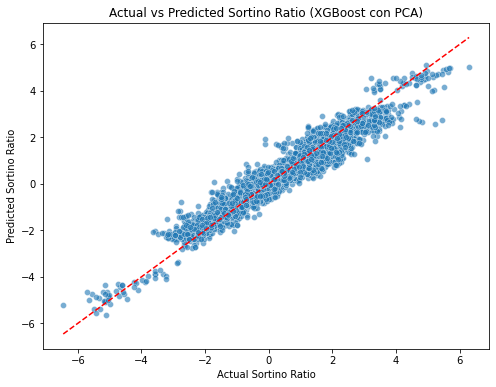

In [7]:
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)


df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA - Manteniendo 95% de varianza explicada
pca = PCA(n_components=21)
X_pca = pca.fit_transform(X_scaled)

# División en Train, Validation y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 250),  # Reducir tamaño del modelo
        'max_depth': trial.suggest_int('max_depth', 3, 4),  # Evitar sobreajuste
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),  # Aprendizaje más estable
        'subsample': trial.suggest_float('subsample', 0.8, 0.95),  # Más ruido
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 1.0),
        'gamma': trial.suggest_float('gamma', 0.02, 0.1),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.6),  # Aumentar regularización
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 0.6)
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalización si R² sigue siendo mayor a 0.95
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  
    return r2_mean  


    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Penalizar modelos con R² > 0.95 para evitar sobreajuste
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  # Penalización
    return r2_mean  

# Optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Entrenar el modelo con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

# Evaluación final
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n Evaluación en Test Set con PCA:\nMSE: {mse:.4f} | R²: {r2:.4f}")

# Visualización
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sortino Ratio")
plt.ylabel("Predicted Sortino Ratio")
plt.title("Actual vs Predicted Sortino Ratio (XGBoost con PCA)")
plt.show()

In [12]:
import pickle

# Guardar el modelo entrenado
with open("xgboost_pca_model.pkl", "wb") as f:
    pickle.dump(best_model, f)



In [10]:
# Implementación del mejor modelo XGBoost optimizado con PCA
xgb_model = xgb.XGBRegressor(
    n_estimators=250,  
    max_depth=4,  
    learning_rate=0.045,  
    subsample=0.87,  
    colsample_bytree=0.91,  
    gamma=0.055,  
    reg_alpha=0.4,  
    reg_lambda=0.5,  
    objective='reg:squarederror'
)

# Entrenar modelo
xgb_model.fit(X_train, y_train)

# Predicciones
preds = xgb_model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n Evaluación Final del Modelo XGBoost Optimizado con PCA:")
print(f"MSE: {mse:.4f} | R²: {r2:.4f}")



 Evaluación Final del Modelo XGBoost Optimizado con PCA:
MSE: 0.2067 | R²: 0.9102
